# Predictive model of Divvy bike share usage 

## Using data downloaded from Divvy website
ZIP files here: https://www.divvybikes.com/system-data
- https://amazonaws.com/divvy-data/Divvy_Trips_2018_Q2.zip

# 1 min video presentation
**https://youtu.be/N5BJv2NNcsE**
## Overview
Hello, my name is Zane Rankin. I'm an avid biker and hope to build a robust model to predict usage of bike share expansion in new neighborhoods and cities. 
## First model 
First, I downloaded data for over 15 million bike share rides in Chicago from 2013 to 2018.
**Figure 1 - size plot by 2015 and 2016**
In this plot we see stations created in 2015 in blue and previous stations in black, with size indicating usage. I use a K-Nearest-Neighbors machine learning algorithm that uses spatial similarity to predict usage. **Figure 2 - PDP** Here we see some results of the trained model, where the algorithm picks up the spatial patterns of downtown and the waterfront.   
## Limitations and directions
**Figure 3 - marker expansion by 2013, 2015, 2016**. 
While the initial model is promising, we see that expansion defies previous spatial patterns, particularly in the recent 2016 expansion shown in red. At the data incubator, I hope to incorporate census data and Google Maps data to capture non-spatial predictors that can generalize better to improve predictions to new neighborhoods and cities. Thanks for your consideration.   

## Detailed project description
I plan to build a model to predict bike share usage. Bike share companies exist in a highly competitive market, with cities such as Seattle having half a dozen competing companies. I want to build a robust model that predicts usage in new neighborhoods and cities.

First, I downloaded data from >15 million rides from Chicago's Divvy bike share service between 2013-2018, as well as the station metadata (e.g. date created, latitude/longitude). Divvy had three major expansions in 2013, 2015, and 2016. As a proof of concept, I built a K-Nearest-Neighbors model using daily usage rates from all stations (n=300) existing in 2014 to predict daily usage rates of the 139 stations built in 2015. The mean absolute error was <8 rides per day. 

However, mapping new stations (particularly ones built in 2016) makes it clear that expansion does not match the spatial patterns of existing stations (ie, putting stations in new neighborhoods). Therefore, a model relying solely on spatial patterns of existing stations does not generalize well for predictions in new neighborhoods (or cities). At the Data Incubator, I would incorporate census data to capture non-spatial predictors that can generalize better to improve predictions to new neighborhoods and cities. I would also explore the use of Google Maps data to get more detailed spatial information, such as travel time between stops (rather than solely latitude/longitude). 

# NOTE
Folium maps do not render on Github, but will be saved as JPEG files in the same repo

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import folium

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
import shap

In [3]:
# Load from lib
%load_ext autoreload 
%autoreload 2

# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from lib.download_data import load_trip_data, load_station_data
from lib.visualization import plot_learning_curve, map_stations
from lib.utils import kfold, report_cv_scores

In [4]:
# %%time
# # To run data download and processing
# from lib.download_data import *
# download_divvy()
# unzip_divvy()
# standardize_unzipped_files()
# aggregate_trip_data()

# Load all trip data 

In [5]:
%%time
df = load_trip_data()

Wall time: 42.5 s


In [6]:
df.shape

(15269084, 13)

In [7]:
df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,start_datetime
0,4118,2013-06-27 12:11,2013-06-27 12:16,480,316,85,Michigan Ave & Oak St,28,Larrabee St & Menomonee St,Customer,NaN,NaN,2013-06-27 12:11:00
1,4275,2013-06-27 14:44,2013-06-27 14:45,77,64,32,Racine Ave & Congress Pkwy,32,Racine Ave & Congress Pkwy,Customer,NaN,NaN,2013-06-27 14:44:00
2,4291,2013-06-27 14:58,2013-06-27 15:05,77,433,32,Racine Ave & Congress Pkwy,19,Loomis St & Taylor St,Customer,NaN,NaN,2013-06-27 14:58:00
3,4316,2013-06-27 15:06,2013-06-27 15:09,77,123,19,Loomis St & Taylor St,19,Loomis St & Taylor St,Customer,NaN,NaN,2013-06-27 15:06:00
4,4342,2013-06-27 15:13,2013-06-27 15:27,77,852,19,Loomis St & Taylor St,55,Halsted St & James M Rochford St,Customer,NaN,NaN,2013-06-27 15:13:00


# Load Station data, and define the research question

In [8]:
stations = load_station_data()

In [9]:
#LAST_TRIP = df['start_datetime'].max()
LAST_TRIP = pd.Timestamp('2018-06-30 23:59:56')
LAST_TRIP

Timestamp('2018-06-30 23:59:56')

In [10]:
stations['online_duration'] = LAST_TRIP - stations['online_datetime']
stations['online_duration_days'] = stations.online_duration.astype(('timedelta64[D]'))

## When we plot the number of days the stations (existing as of the end of 2017) have been online, we see that most were built in 2013, 2015, or 2016

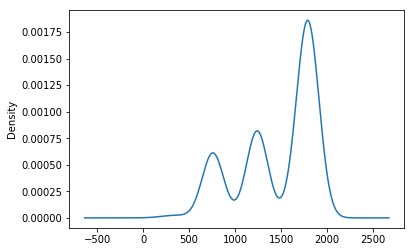

In [11]:
stations.online_duration_days.plot.kde()

In [12]:
stations.groupby('online_month')['online_month'].agg('count')

online_month
2013-06    86
2013-07    85
2013-08    67
2013-09    79
2013-10    13
2013-12     2
2014-01     1
2014-03     1
2014-04     1
2015-01    61
2015-02    79
2016-05    80
2016-06    23
2016-07     2
2017-04     1
2017-06     1
2017-07     1
2017-08     1
2017-12     1
Name: online_month, dtype: int64

In [13]:
df['trips'] = 1
trip_counts = df.groupby(['from_station_id'])['trips'].agg('sum').reset_index()
trip_counts = trip_counts.rename(columns={'from_station_id':'id'})

In [14]:
df_stations = pd.merge(stations, trip_counts)
df_stations['trips_per_day'] = df_stations.trips / df_stations.online_duration_days
df_stations.shape

(585, 15)

In [15]:
d = {2013:'black', 2014:'blue', 2015: 'green', 2016: 'orange', 2017: 'red'}
df_stations['color'] = df_stations['online_year'].map(d)

In [16]:
INDICATOR = 'trips_per_day'

In [17]:
map_stations(df_stations, INDICATOR)

## Okay, we see the spread of stations from heavily used areas (e.g. downtown) outward

## Define training & testing data & subset trips: 
The simplest model would be randomly assigning stations to train or test set. However, to simulate a realistic scenario, I want to predict a year of usage of newly implemented stations, in this case the ones built in early 2015. The training set will be the usage of existing stations over the previous year. 
- `train` period: between 2014/03/01 and 2015/03/01
- `test` period: between 2015/03/01 and 2016/03/01

In [18]:
test_station_ids = stations.query('online_date > "2015-01-01" & online_date < "2015-02-28"').id.unique().tolist()
len(test_station_ids)

140

In [19]:
train_station_ids = stations.query('online_date < "2014-02-30"').id.unique().tolist()
len(train_station_ids)

333

In [20]:
df.rename(columns={'from_station_id':'id'}, inplace=True)
df['trips'] = 1
df.set_index('id', inplace=True)
train_start = pd.Timestamp('2014-03-01')
train_stop = pd.Timestamp('2015-03-01')
test_start = train_stop
test_stop = pd.Timestamp('2016-03-01')

In [21]:
df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,start_datetime,trips
id,,,,,,,,,,,,,
85,4118,2013-06-27 12:11,2013-06-27 12:16,480,316,Michigan Ave & Oak St,28,Larrabee St & Menomonee St,Customer,NaN,NaN,2013-06-27 12:11:00,1
32,4275,2013-06-27 14:44,2013-06-27 14:45,77,64,Racine Ave & Congress Pkwy,32,Racine Ave & Congress Pkwy,Customer,NaN,NaN,2013-06-27 14:44:00,1
32,4291,2013-06-27 14:58,2013-06-27 15:05,77,433,Racine Ave & Congress Pkwy,19,Loomis St & Taylor St,Customer,NaN,NaN,2013-06-27 14:58:00,1
19,4316,2013-06-27 15:06,2013-06-27 15:09,77,123,Loomis St & Taylor St,19,Loomis St & Taylor St,Customer,NaN,NaN,2013-06-27 15:06:00,1
19,4342,2013-06-27 15:13,2013-06-27 15:27,77,852,Loomis St & Taylor St,55,Halsted St & James M Rochford St,Customer,NaN,NaN,2013-06-27 15:13:00,1


In [22]:
df_train = df.loc[train_station_ids]
training_period = (df_train.start_datetime > train_start) & (df_train.start_datetime < train_stop)
df_train = df_train.loc[training_period]

trip_counts = df_train.reset_index().groupby(['id'])['trips'].agg('sum').reset_index()
df_train = pd.merge(stations, trip_counts)
df_train['trips_per_day'] = df_train.trips / 365
df_train.shape

(300, 15)

In [23]:
df_test = df.loc[test_station_ids]
testing_period = (df_test.start_datetime > test_start) & (df_test.start_datetime < test_stop)
df_test = df_test.loc[testing_period]

trip_counts = df_test.reset_index().groupby(['id'])['trips'].agg('sum').reset_index()
df_test = pd.merge(stations, trip_counts)
df_test['trips_per_day'] = df_test.trips / 365
df_test.shape

(139, 15)

In [24]:
d = {2013: 'black', 2015: 'blue', 2016: 'red'}
df_stations = pd.concat([df_train, df_test]).set_index('id')
df_stations['color'] = df_stations['online_year'].map(d)
map_stations(df_stations, INDICATOR)

# Build Model 

In [25]:
map_stations(df_stations, INDICATOR)

In [26]:
INDICATOR = 'trips_per_day'
features = ['latitude', 'longitude']
X_train = df_train[features]
y_train = df_train[INDICATOR]
X_test = df_test[features]
y_test = df_test[INDICATOR]

In [27]:
model = KNeighborsRegressor(n_neighbors=8, weights='distance')
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=8, p=2,
          weights='distance')

Wall time: 4 s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

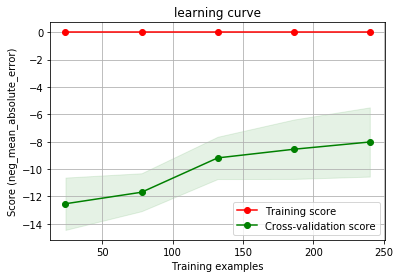

In [28]:
%%time
plot_learning_curve(model, 'learning curve', X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

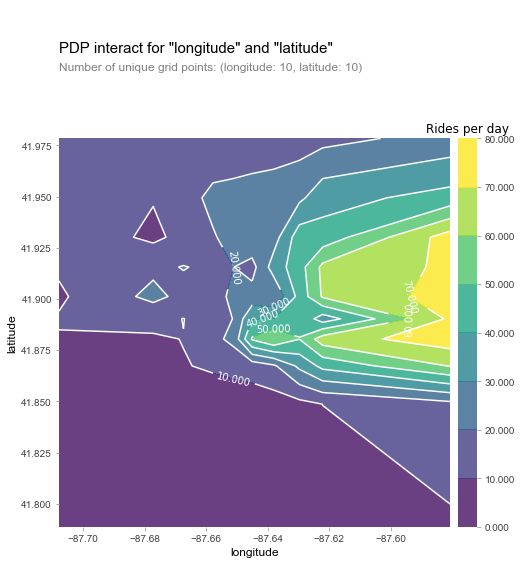

In [29]:
features_to_plot = ['longitude', 'latitude']
inter1  =  pdp.pdp_interact(model=model, dataset=X_train, model_features=X_train.columns.tolist(), features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.title('Rides per day')
plt.show()

In [30]:
d = {2013: 'black', 2015: 'blue', 2016: 'red'}
stations['color'] = stations['online_year'].map(d)
map_stations(stations)

In [31]:
BREAK

NameError: name 'BREAK' is not defined

# SCRATCH 
(some of this is from the original model with a temporal cross-section of training & test data)

# Merge to station info and plot

In [ ]:
df_stations = pd.merge(stations, trip_counts)
df_stations['trips_per_day'] = df_stations.trips / df_stations.online_duration_days
df_stations.shape

In [ ]:
df_stations = df_stations.set_index('id').loc[train_station_ids + test_station_ids]

In [ ]:
df_stations.shape

In [ ]:
df_stations.sort_values(INDICATOR, ascending=False).head(10)

In [ ]:
df_stations.sort_values(INDICATOR, ascending=False).tail(10)

## Map the 20 most used locations (there are >500)

In [ ]:
df_stations.loc[train_station_ids, 'color'] = 'blue'
df_stations.loc[test_station_ids, 'color'] = 'red'

In [ ]:
INDICATOR = 'trips_per_day'

In [ ]:
map_stations(df_stations, INDICATOR)

## Here are some other map ideas

In [ ]:
locations = df_stations.sort_values(INDICATOR, ascending=False)[['latitude', 'longitude']]
locationlist = locations.values.tolist()
len(locationlist)

In [ ]:
m = folium.Map(location=[41.9, -87.62], zoom_start=13)

for point in range(0, 20):
    folium.PolyLine((locationlist[point], locationlist[point+1]), color="blue", weight=df_stations.iloc[point]['trips']/5000, opacity=1).add_to(m)
m

In [ ]:
m = folium.Map(location=[41.9, -87.62], zoom_start=13)
for point in range(0, 10):
    folium.Marker(locationlist[point], popup=str(df_stations[INDICATOR][point])).add_to(m)
m

## Get distance matrix
Want distance from each station to every other

In [ ]:
station_ids = df_stations.id.unique().tolist()
len(station_ids)

In [ ]:
def calc_linear_distance(lat1, lat2, long1, long2):
    dist = np.sqrt((lat2 - lat1)**2 + (long2 - long1)**2)
    return dist

for station in station_ids:
    lat2 = float(df_stations.loc[df_stations['id'] == station]['latitude'])
    long2 = float(df_stations.loc[df_stations['id'] == station]['longitude'])
    df_stations[f'd_{station}'] = calc_linear_distance(df_stations.latitude, lat2, 
                                                      df_stations.longitude, long2)

In [ ]:
df_stations.head()

In [ ]:
distance_features = [col for col in df_stations.columns if 'd_' in col]
np.random.seed(42)
some_distance_features = list(np.random.choice(distance_features, 50)) # should I set probability to 
some_distance_features

In [ ]:
features = ['latitude', 'longitude'] # + some_distance_features # + [col for col in df_stations.columns if 'd_' in col]
X = df_stations[features]
y = df_stations[INDICATOR]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# X_train = X.loc[train_station_ids]
# y_train = y.loc[train_station_ids]
# X_test = X.loc[test_station_ids]
# y_test = y.loc[test_station_ids]

In [ ]:
# model = RandomForestRegressor(max_depth=4, n_estimators=50, random_state=42)
# model = LinearRegression()
#model = KNeighborsRegressor(n_neighbors=5, weights='distance')
model = KNeighborsRegressor(n_neighbors=10, weights='uniform')
# model = SVC()

In [ ]:
%%time
param_grid = dict(n_neighbors=[5,7,10,12,15],
                 weights=['uniform', 'distance'])
grid = GridSearchCV(model, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

In [ ]:
report_cv_scores(grid.cv_results_)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
preds = model.predict(X_train)
preds[:10]

In [ ]:
y_train[:10]

In [ ]:
%%time
plot_learning_curve(model, 'learning curve', X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

In [ ]:
pdp_tempmax = pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns.tolist(), feature='longitude')
pdp.pdp_plot(pdp_tempmax, 'longitude')
plt.show()

In [ ]:
pdp_tempmax = pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns.tolist(), feature='latitude')
pdp.pdp_plot(pdp_tempmax, 'latitude')
plt.show()

In [ ]:
features_to_plot = ['longitude', 'latitude']
inter1  =  pdp.pdp_interact(model=model, dataset=X_train, model_features=X_train.columns.tolist(), features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

In [ ]:
feature_to_coef = {
    feature: coef for feature, coef in zip(
        X.columns, lm.coef_
    )
}

print('Most positively associated words')
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
print('\n Most negatively associated words')
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)